In [6]:
## %%writefile Euler_1D.py
## Convertit la fonction définie ici dans un scipt Python

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

def Euler_1D(pb, flx_type, nc, cfl, vplt):
    
    if vplt == 1:
        plt.close('all')

    if pb == 1:
        xd, xf, xdis = 0, 1, 0.5
        gam, tfin = 1.4, 0.2
        den_L, pre_L, vit_L = 1, 1, 0
        den_R, pre_R, vit_R = 0.125, 0.1, 0
    elif pb == 2:
        xd, xf, xdis = 0, 1, 0.5
        gam, tfin = 1.4, 0.15
        den_L, pre_L, vit_L = 1, 0.4, -2
        den_R, pre_R, vit_R = 1, 0.4, 2

    dx = (xf - xd) / nc
    xint = np.linspace(xd, xf, nc + 1)
    xi = np.arange(xd + dx / 2, xf - dx / 2 + dx / 2, dx)

    den = np.zeros(nc)
    vit = np.zeros(nc)
    pre = np.zeros(nc)
    mom = np.zeros(nc)
    ene = np.zeros(nc)
    cel = np.zeros(nc)
    Vsol = np.zeros((nc, 3))

    for ii in range(nc):
        if xint[ii + 1] <= xdis:
            den[ii], pre[ii], vit[ii] = den_L, pre_L, vit_L
        else:
            den[ii], pre[ii], vit[ii] = den_R, pre_R, vit_R

        mom[ii] = den[ii] * vit[ii]
        ene[ii] = pre[ii] / (gam - 1) + den[ii] * vit[ii] ** 2 / 2
        cel[ii] = np.sqrt(pre[ii] * gam / den[ii])

        Vsol[ii, 0] = den[ii]
        Vsol[ii, 1] = mom[ii]
        Vsol[ii, 2] = ene[ii]

    tps = 0
    flux_int = np.zeros((nc + 1, 3))
    n_it = 0

    while tps < tfin:
        dt = cfl * dx / np.max(cel + np.abs(vit))
        if tps + dt > tfin + 1e-6:
            dt = tfin - tps

        flux_int[0, :] = flux_num(Vsol[0, :], Vsol[0, :], gam, flx_type)
        for ii in range(nc):
            if ii < nc - 1:
                flux_int[ii + 1, :] = flux_num(Vsol[ii, :], Vsol[ii + 1, :], gam, flx_type)
            else:
                flux_int[ii + 1, :] = flux_num(Vsol[ii, :], Vsol[ii, :], gam, flx_type)

            Vsol[ii, :] -= dt / dx * (flux_int[ii + 1, :] - flux_int[ii, :])

            den[ii] = Vsol[ii, 0]
            vit[ii] = Vsol[ii, 1] / Vsol[ii, 0]
            pre[ii] = (gam - 1) * (Vsol[ii, 2] - 0.5 * (Vsol[ii, 1] ** 2) / Vsol[ii, 0])
            cel[ii] = np.sqrt(pre[ii] * gam / den[ii])

        tps += dt
        n_it += 1

    if pb == 1:
        file_den_sol = 'Sol_exactes/sod_den.dat'
        file_eni_sol = 'Sol_exactes/sod_eni.dat'
    elif pb == 2:
        file_den_sol = 'Sol_exactes/dbl_det_den.dat'
        file_eni_sol = 'Sol_exactes/dbl_det_eni.dat'

    with open(file_den_sol, 'r') as fid_den, open(file_eni_sol, 'r') as fid_eni:
        TT = fid_den.read()
        ss = sum(c == '\n' for c in TT)
        fid_den.seek(0)

        xs = np.zeros(ss)
        den_sol = np.zeros(ss)
        eni_sol = np.zeros(ss)

        for ii in range(ss):
            a_den = np.array([float(val) for val in fid_den.readline().split()])
            a_eni = np.array([float(val) for val in fid_eni.readline().split()])

            xs[ii] = a_den[0]
            den_sol[ii] = a_den[1]
            eni_sol[ii] = a_eni[1]

    if vplt == 1:
        plt.figure(1, figsize=(10, 8))
        plt.plot(xs, den_sol, '-r', linewidth=3)
        plt.plot(xi, den, '-db')
        plt.xlabel('x')
        plt.ylabel('densité')
        plt.title("Densité à l'instant final")
        plt.legend(['solution exacte', 'schéma Eulérien'], loc='upper right')

        plt.figure(2, figsize=(10, 8))
        plt.plot(xs, eni_sol, '-r', linewidth=3)
        plt.plot(xi, pre / ((gam - 1) * den), '-db')
        plt.xlabel('x')
        plt.ylabel('énergie interne')
        plt.title("Énergie interne à l'instant final")
        plt.legend(['solution exacte', 'schéma Eulérien'], loc='upper left')
    else:
        return xs,den_sol,eni_sol,xi,den,pre / ((gam - 1) * den)

    plt.show()


def flux_num(VL, VR, gam, flx_type):
    den_L = VL[0]
    vit_L = VL[1] / VL[0]
    pre_L = (gam - 1) * (VL[2] - 0.5 * (VL[1] ** 2) / VL[0])
    cel_L = np.sqrt(pre_L * gam / den_L)

    den_R = VR[0]
    vit_R = VR[1] / VR[0]
    pre_R = (gam - 1) * (VR[2] - 0.5 * (VR[1] ** 2) / VR[0])
    cel_R = np.sqrt(pre_R * gam / den_R)

    FL = np.zeros(3)
    FL[0] = VL[1]
    FL[1] = den_L * vit_L ** 2 + pre_L
    FL[2] = (VL[2] + pre_L) * vit_L

    FR = np.zeros(3)
    FR[0] = VR[1]
    FR[1] = den_R * vit_R ** 2 + pre_R
    FR[2] = (VR[2] + pre_R) * vit_R

    if flx_type == 1:
        S0 = max(cel_L + np.abs(vit_L), cel_R + np.abs(vit_R))
        FF = 0.5 * (FL + FR - S0 * (VR - VL))
    elif flx_type == 2:
        SL = min(vit_L - cel_L, vit_R - cel_R)
        SR = max(vit_L + cel_L, vit_R + cel_R)
        if SL >= 0:
            FF = FL
        elif SL <= 0 and SR >= 0:
            FF = (SR * FL - SL * FR + SL * SR * (VR - VL)) / (SR - SL)
        else:
            FF = FR
    else:
        SL = min(vit_L - cel_L, vit_R - cel_R)
        SR = max(vit_L + cel_L, vit_R + cel_R)
        S0 = den_R * vit_R * (SR - vit_R) - den_L * vit_L * (SL - vit_L) - pre_R + pre_L
        S0 = S0 / (den_R * (SR - vit_R) - den_L * (SL - vit_L))

        VVL = np.zeros(3)
        VVL[0] = den_L * (SL - vit_L) / (SL - S0)
        VVL[1] = VVL[0] * S0
        VVL[2] = VVL[0] * (VL[2] / den_L + (S0 - vit_L) * (S0 + pre_L / (den_L * (SL - vit_L))))

        VVR = np.zeros(3)
        VVR[0] = den_R * (SR - vit_R) / (SR - S0)
        VVR[1] = VVR[0] * S0
        VVR[2] = VVR[0] * (VR[2] / den_R + (S0 - vit_R) * (S0 + pre_R / (den_R * (SR - vit_R))))

        if SL >= 0:
            FF = FL
        elif SL <= 0 and S0 >= 0:
            FF = FL + SL * (VVL - VL)
        elif S0 <= 0 and SR >= 0:
            FF = FR + SR * (VVR - VR)
        else:
            FF = FR

    return FF



## Voici un exemple de comment appeler la funtion
## Euler_1D(1, 3, 100, 0.9, 1)


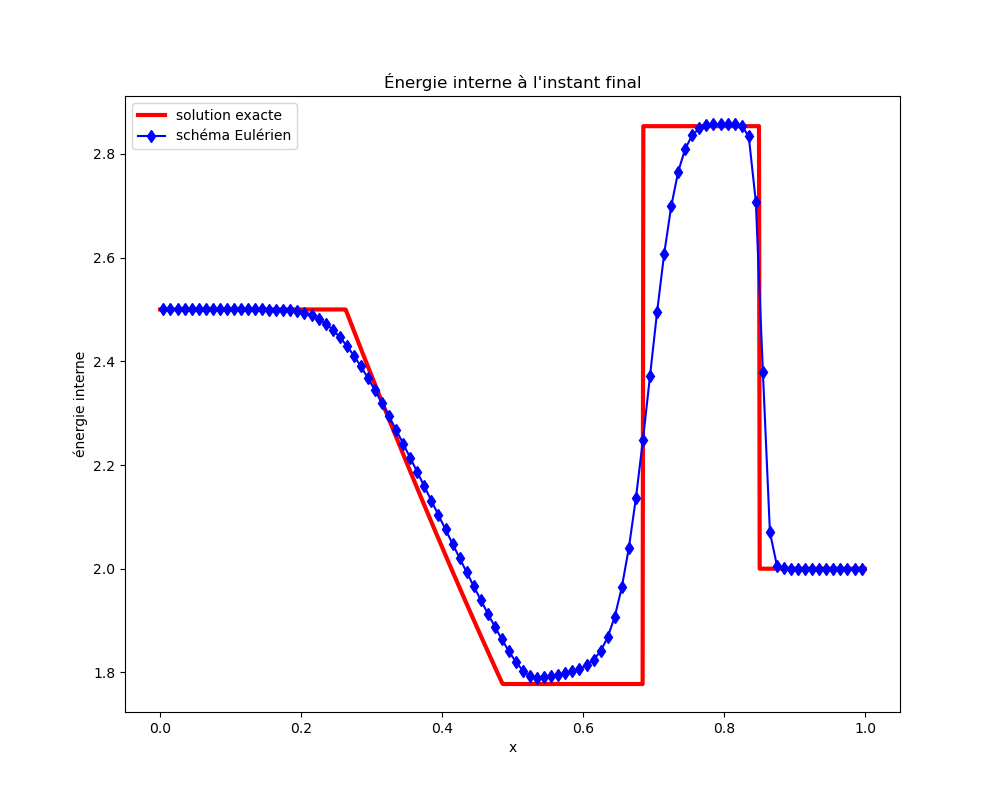

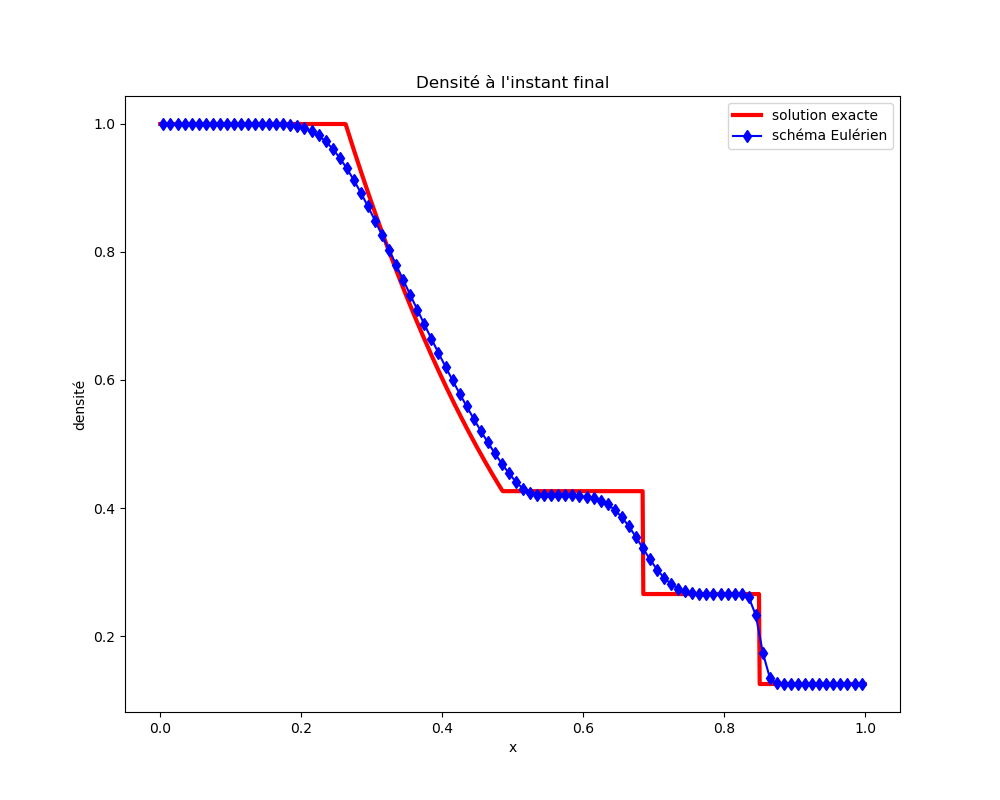

In [7]:
Euler_1D(1, 3, 100, 0.9, 1)